In [2]:
%pylab inline
import theano
import theano.tensor.signal.downsample
from common.plotting import plot_mat
from utils import *
import time

from IPython.display import SVG
def svgdotprint(g):
    return SVG(theano.printing.pydotprint(g, return_image=True, format='svg'))

Populating the interactive namespace from numpy and matplotlib


Using gpu device 0: GeForce GT 740M


In [3]:
from prepare_cifar10 import *

cifar = prepare_cifar10()

cifar_train = cifar.train
cifar_train_stream = cifar.train_stream
                                               
cifar_validation = cifar.validation
cifar_validation_stream = cifar.validation_stream

cifar_test = cifar.test
cifar_test_stream = cifar.test_stream

print("The streams return batches containing %s" % (cifar_train_stream.sources,))

print("Each trainin batch consits of a tuple containing:")
for element in next(cifar_train_stream.get_epoch_iterator()):
    print(" - an array of size %s containing %s" % (element.shape, element.dtype))
    
print("Validation/test batches consits of tuples containing:")
for element in next(cifar_test_stream.get_epoch_iterator()):
    print(" - an array of size %s containing %s" % (element.shape, element.dtype))

The streams return batches containing ('features', 'targets')
Each trainin batch consits of a tuple containing:
 - an array of size (100, 3, 32, 32) containing float32
 - an array of size (100, 1) containing uint8
Validation/test batches consits of tuples containing:
 - an array of size (100, 3, 32, 32) containing float32
 - an array of size (100, 1) containing uint8


In [72]:
from utils import *

def conv2D(num_in_filters, num_out_filters, kernel_size, name = None):
    name = name if name else fresh_name("?")
        
    weights_shape = (num_out_filters, num_in_filters, kernel_size, kernel_size)
    weights_name = "{}.weights".format(name)
    weights = theano.shared(np.zeros(weights_shape, dtype = 'float32'), name = weights_name)
    weights.tag.initializer = IsotropicGaussian(0.05)
    
    biases_shape = (num_out_filters,)
    biases_name = "{}.biases".format(name)
    biases = theano.shared(np.zeros(biases_shape, dtype='float32'), biases_name)
    biases.tag.initializer = Constant(0.0)
    
    def fprop(X):
        return theano.tensor.nnet.conv2d(X, weights) + biases.dimshuffle('x', 0, 'x', 'x')
    
    fprop.params = [weights, biases]
    
    return fprop

def relu(name = fresh_name("?")):
    def fprop(X):
        return theano.tensor.maximum(0.0, X)
    
    return fprop
    
def max_pool_2d(kernel_size):
    def fprop(X):
        kernel_shape = (kernel_size, kernel_size)
        return theano.tensor.signal.downsample.max_pool_2d(X, kernel_shape, ignore_border = True)

    return fprop

def flatten(num_inputs, num_outputs, name = None):
    name = name if name else fresh_name("?")
        
    weights_shape = (num_inputs, num_outputs)
    weights_name = "{}.weights".format(name)
    weights = theano.shared(np.zeros(weights_shape, dtype='float32'), name = weights_name)
    weights.tag.initializer = IsotropicGaussian(0.05)
    
    biases_shape = (num_outputs, )
    biases_name = "{}.biases".format(name)
    biases = theano.shared(np.zeros(biases_shape, dtype='float32'), name = biases_name)
    biases.tag.initializer = Constant(0.0)
    
    def fprop(X):
        return theano.tensor.dot(X.flatten(2), weights) + biases.dimshuffle('x', 0)

    fprop.params = [weights, biases]
    
    return fprop
    
def xaffine(num_inputs, num_outputs, name = None):    
    name = name if name else fresh_name("?")
    
    weights_shape = (num_inputs, num_outputs)
    weights_name = "{}.weights".format(name)
    weights = theano.shared(np.zeros(weights_shape, dtype='float32'), name = weights_name)
    weights.tag.initializer = IsotropicGaussian(0.05)
    
    biases_shape = (num_outputs, )
    biases_name = "{}.biases".format(name)
    biases = theano.shared(np.zeros(biases_shape, dtype='float32'), name = biases_name)
    biases.tag.initializer = Constant(0.0)
    
    def fprop(X):
        return theano.tensor.dot(X, weights) + biases.dimshuffle('x', 0)

    fprop.params = [weights, biases]
    
    return fprop
    
def maxout(num_inputs, num_outputs, degree, name = None):
    name = name if name else fresh_name("?")
    
    weights_shape = (num_outputs, num_inputs, degree)
    weights_name = "{}.weights".format(name)
    weights = theano.shared(np.zeros(weights_shape, dtype='float32'), name = weights_name)
    weights.tag.initializer = IsotropicGaussian(0.05)
    
    biases_shape = (num_outputs, degree)
    biases_name = "{}.biases".format(name)
    biases = theano.shared(np.zeros(biases_shape, dtype='float32'), name = biases_name)
    biases.tag.initializer = Constant(0.0)
    
    def fprop(X):
        return theano.tensor.max(theano.tensor.dot(X, weights) + biases.dimshuffle('x', 0, 1), axis = 2)
    
    fprop.params = [weights, biases]
    
    return fprop
    
def softmax():
    def fprop(X):
        return theano.tensor.nnet.softmax(X)

    return fprop
    
def compose(*args):
    def fprop(X):
        for arg in args:
            X = arg(X)
        return X
    
    params = []

    for arg in args:
        try:
            params += arg.params
        except AttributeError:
            pass
    
    if params != []:
        fprop.params = params
    
    return fprop


In [73]:
def compile(template):
    X = theano.tensor.tensor4('X', dtype = 'float32')
    Y = theano.tensor.matrix('Y', dtype = 'uint8')
    
    model_parameters = template.params

    log_probs = template(X)

    predictions = theano.tensor.argmax(log_probs, axis = 1)

    error_rate = theano.tensor.neq(predictions,Y.ravel()).mean()
    nll = - theano.tensor.log(log_probs[theano.tensor.arange(Y.shape[0]), Y.ravel()]).mean()

    weight_decay = 0.0
    for p in model_parameters:
        if p.name.endswith('weights'):
            weight_decay = weight_decay + 1e-3 * (p ** 2).sum()

    cost = nll + weight_decay
    
    learn_rate = theano.tensor.scalar('learn_rate', dtype = 'float32')
    momentum = theano.tensor.scalar('momentum', dtype = 'float32')

    # Theano will compute the gradients for us
    gradients = theano.grad(cost, model_parameters)

    #initialize storage for momentum
    velocities = [theano.shared(np.zeros_like(p.get_value()), name='V_%s' %(p.name, )) for p in model_parameters]
    
    updates = []

    for p, g, v in zip(model_parameters, gradients, velocities):
        if p.name.endswith("weights"):
            g += 1e-3 * p
        v_new = momentum * v - learn_rate * g
        p_new = p + v_new
        updates += [(v, v_new), (p, p_new)]
            
    def step_ex(X, Y, learn_rate, momentum):
        return step(X, Y, learn_rate, momentum)
    
    def init_parameters():
        rng = numpy.random.RandomState(1234)
        
        for p in model_parameters:
            p.set_value(p.tag.initializer.generate(rng, p.get_value().shape))
            
        for v in velocities:
            v.set_value(np.zeros_like(v.get_value()))
            
    step = theano.function(
        [X, Y, learn_rate, momentum],
        [cost, error_rate, nll, weight_decay],
        updates = updates, 
        allow_input_downcast = True)
            
    predict = theano.function([X], predictions)
    
    init_parameters()
    
    class Network:
        def snapshot(self):
            return [p.get_value(borrow = False) for p in self.params]
    
        def load(self, snapshot):
            for p, s in zip(self.params, snapshot):
                p.set_value(s, borrow = False)
    
    network = Network()
    network.step = step_ex
    network.predict = predict
    network.params = model_parameters

    return network


In [74]:
def train(network, learn_rate0, momentum):
    batch = 0
    epoch = 0

    best_valid_error_rate = np.inf
    best_params = network.snapshot()
    best_params_epoch = 0

    train_erros = []
    train_loss = []
    train_nll = []
    validation_errors = []

    number_of_epochs = 3
    patience_expansion = 1.5

    # training loop
    try:
        start = time.time()
        
        while epoch < number_of_epochs: #This loop goes over epochs
            epoch += 1
            #First train on all data from this batch

            epoch_start_batch = batch

            for X_batch, Y_batch in cifar_train_stream.get_epoch_iterator(): 
                batch += 1

                # learn_rate = learn_rate0 * (1 - np.tanh(batch * 0.549306 / 2000))
                
                K = 2000
                learn_rate = learn_rate0 * K / np.maximum(K, batch)
                
                L, err_rate, nll, wdec = network.step(X_batch, Y_batch, learn_rate, momentum)

                train_loss.append((batch, L))
                train_erros.append((batch, err_rate))
                train_nll.append((batch, nll))

                if batch % 100 == 0:
                    end = time.time()
                    elapsed = end - start
                    start = end
                    format = "At minibatch %d, batch loss %f, batch nll %f, batch error rate %f%%, time %.2fms"
                    print(format % (batch, L, nll, err_rate * 100, elapsed / Y_batch.shape[0] * 1000), flush = True)

            # After an epoch compute validation error
            val_error_rate = compute_error_rate(cifar_validation_stream, network.predict)
            if val_error_rate < best_valid_error_rate:
                number_of_epochs = np.maximum(number_of_epochs, epoch * patience_expansion + 1)
                best_valid_error_rate = val_error_rate
                best_params = network.snapshot()
                best_params_epoch = epoch
            validation_errors.append((batch, val_error_rate))

            print("After epoch %d: valid_err_rate: %f%% currently going to do %d epochs" %(
                epoch, val_error_rate * 100, number_of_epochs))
            print("After epoch %d: averaged train_err_rate: %f%% averaged train nll: %f averaged train loss: %f" %(
                epoch, np.mean(np.asarray(train_erros)[epoch_start_batch:, 1]) * 100, 
                np.mean(np.asarray(train_nll)[epoch_start_batch:, 1]),
                np.mean(np.asarray(train_loss)[epoch_start_batch:, 1])))
    except KeyboardInterrupt:
        print("Setting network parameters from after epoch %d" %(best_params_epoch))
        network.load(best_params)
        
        subplot(2,1,1)
        train_nll_a = np.array(train_nll)
        semilogy(train_nll_a[:,0], train_nll_a[:,1], label='batch train nll')
        legend()

        subplot(2,1,2)
        train_erros_a = np.array(train_erros)
        plot(train_erros_a[:,0], train_erros_a[:,1], label='batch train error rate')
        validation_errors_a = np.array(validation_errors)
        plot(validation_errors_a[:,0], validation_errors_a[:,1], label='validation error rate', color='r')
        ylim(0,0.2)
        legend()


In [ ]:
nn = compose(conv2D(3, 64, 5), 
             relu(), 
             max_pool_2d(2),
             conv2D(64, 25, 5),
             relu(),
             max_pool_2d(2),
             flatten(625, 200),
             relu(),
             xaffine(200, 10), 
             softmax()
            )

nn = compose(conv2D(3, 64, 5), 
             relu(), 
             max_pool_2d(2),
             conv2D(64, 64, 5),
             relu(),
             max_pool_2d(2),
             flatten(1600, 128),
             relu(),
             maxout(128, 10, 4),
             softmax()
            )

print("Compiling...", end = " ", flush = True)
network = compile(nn)
print("DONE", flush = True)

train(network, 4e-3, 0.9)

Compiling... 

INFO (theano.gof.compilelock): Refreshing lock /home/wojciech/.theano/compiledir_Linux-3.19--generic-x86_64-with-LinuxMint-17.3-rosa-x86_64-3.4.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/wojciech/.theano/compiledir_Linux-3.19--generic-x86_64-with-LinuxMint-17.3-rosa-x86_64-3.4.3-64/lock_dir/lock


DONE
At minibatch 100, batch loss 2.747560, batch nll 1.966893, batch error rate 68.000000%, time 255.62ms


In [35]:

print("Test error rate is %f%%" %(compute_error_rate(cifar_test_stream, network.predict) * 100.0,))



Test error rate is 28.640000%


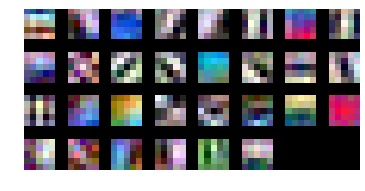

In [31]:
#How do the filters in the first layer look like?

for param in network.params:
    if param.name.endswith('weights'):
        plot_mat(param.get_value(), cmap='gray')
        break

In [40]:
iii = network.predict.maker.inputs[0]
X = iii.variable

In [41]:
# build a function that shows how the network processes an image

middle_layers_computer = theano.function([X], [
        X,
        after_C1,
        after_P1,
        after_C2,
        after_P2
        ])


NameError: name 'after_C1' is not defined

In [ ]:
img_num=4

middle_layers = middle_layers_computer(X_test_value[img_num:img_num+1])

for ml, name in zip(middle_layers, ['X', 'C1', 'P1', 'C2', 'P2']):
    plot_mat(ml.transpose(1,0,2,3), cmap='gray')
    title(name)
    show()